# Adam vs CPropAdam on Cifar10

In [21]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from cprop import *

In [3]:
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import *

In [5]:
transform = Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize([0.50707516, 0.48654887, 0.44091784],
              [0.26733429, 0.25643846, 0.27615047])
])

test_transform = Compose([
    ToTensor(),
    Normalize([0.50707516, 0.48654887, 0.44091784],
              [0.26733429, 0.25643846, 0.27615047])
])

In [6]:
train_dataset = CIFAR10('./dataset', train=True, download=True, transform=transform)

Files already downloaded and verified


In [7]:
test_dataset = CIFAR10('./dataset', train=False, download=True, transform=test_transform)

Files already downloaded and verified


In [8]:
from torch.utils.data import DataLoader, TensorDataset

In [9]:
def make_model():
    net = nn.Sequential(
        nn.Conv2d(3, 32, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(64, 64, 3),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(1024, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
    )
    return net

In [10]:
def accuracy(y_hat, y):
    assert y_hat.dim() == 2
    return (torch.argmax(y_hat, dim=1) == y).float().mean()

In [13]:
def step(net, x, y):
    x = x.to(device)
    y = y.to(device)
    pred = net(x)
    loss = F.cross_entropy(pred, y)
    acc = accuracy(pred, y)
    return loss, acc


@torch.no_grad()
def eval(net, loader):
    n = 0
    avg_loss = 0
    avg_acc = 0
    for x, y in loader:
        loss, acc = step(net, x, y)
        n += len(x)
        avg_loss += len(x) / n * (loss.item() - avg_loss)
        avg_acc += len(x) / n * (acc.item() - avg_acc)
    return avg_loss, avg_acc


def run(n_max_itr, lr, use_cprob, bs=32, n_eval_cycle=1000):
    train_loader = DataLoader(train_dataset, batch_size=bs)
    test_loader = DataLoader(test_dataset, batch_size=bs)
    net = make_model().to(device)

    if use_cprob:
        opt = CPropAdam(net.parameters(),
                        lr,
                        cprop_beta=0.999,
                        cprop_c=1,
                        cprop_cdf='bft')
    else:
        opt = optim.Adam(net.parameters(), lr)

    train_stats = defaultdict(list)
    test_stats = defaultdict(list)
    i_itr = 1
    with tqdm(total=n_max_itr) as p:
        while i_itr <= n_max_itr:
            for x, y in train_loader:
                loss, acc = step(net, x, y)

                opt.zero_grad()
                loss.backward()
                opt.step()

                train_stats['i_itr'].append(i_itr)
                train_stats['loss'].append(loss.item())
                train_stats['acc'].append(acc.item())

                if i_itr % n_eval_cycle == 0:
                    loss, acc = eval(net, test_loader)
                    test_stats['i_itr'].append(i_itr)
                    test_stats['test_loss'].append(loss)
                    test_stats['test_acc'].append(acc)

                i_itr += 1
                p.update()
                if i_itr > n_max_itr:
                    break

    train_stats = pd.DataFrame(train_stats)
    test_stats = pd.DataFrame(test_stats)
    stats = pd.merge(train_stats, test_stats, 'outer')
    return stats


In [22]:
def plot(df, key, smooth=None, **kwargs):
    df = df[df[key].notna()]
    if smooth:
        df[key] = df[key].rolling(smooth).mean()
    df.plot('i_itr', key, **kwargs)

# LR selection

In [16]:
device = 'cuda'
df = {}

In [17]:
df['adam1e-3'] = run(5000, 1e-3, use_cprob=False)

100%|██████████| 5000/5000 [00:44<00:00, 111.49it/s]


In [18]:
df['adam3e-3'] = run(5000, 3e-3, use_cprob=False)

100%|██████████| 5000/5000 [00:45<00:00, 111.08it/s]


In [24]:
df['adam1e-4'] = run(5000, 1e-4, use_cprob=False)

100%|██████████| 5000/5000 [00:45<00:00, 110.70it/s]


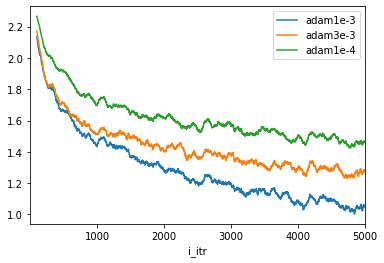

In [25]:
ax = plt.subplot()
for k, v in df.items():
    plot(v, 'loss', smooth=100, ax=ax, label=k)

# Adam vs CPropAdam

In [26]:
dfs2 = {}

In [29]:
dfs2['adam'] = run(15000, 1e-3, use_cprob=False)

100%|██████████| 15000/15000 [02:15<00:00, 110.76it/s]


In [30]:
dfs2['cprop'] = run(15000, 1e-3, use_cprob=True)

100%|██████████| 15000/15000 [02:22<00:00, 105.20it/s]


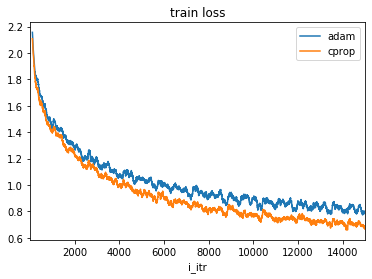

In [37]:
ax = plt.subplot()
ax.set_title('train loss')
for k, v in dfs2.items():
    plot(v, 'loss', smooth=100, ax=ax, label=k)

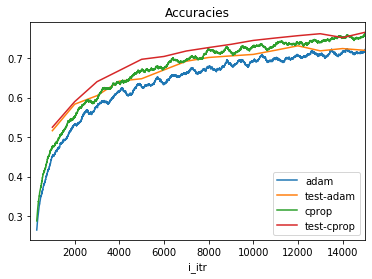

In [43]:
ax = plt.subplot()
ax.set_title('Accuracies')
for k, v in dfs2.items():
    plot(v, 'acc', smooth=300, ax=ax, label=k)
    plot(v, 'test_acc', ax=ax, label=f'test-{k}')
plt.savefig('cifar10_small.png')